<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss,
                             precision_recall_fscore_support, classification_report, 
                             accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [5]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [6]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:33<00:00, 35.45it/s]


In [7]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [8]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [9]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


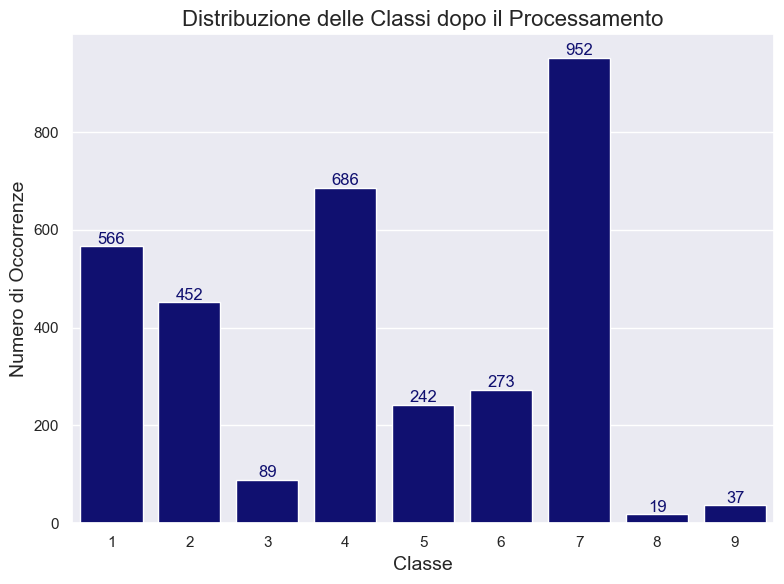

In [10]:
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, color='navy')  # Imposta un colore uniforme per le barre

# Titolo e etichette
plt.title('Distribuzione delle Classi dopo il Processamento', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Aggiungere il numero sopra ogni barra con lo stesso colore della barra
for p in ax.patches:
    height = int(p.get_height())  # Otteniamo l'altezza della barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                xytext=(0, 5), textcoords='offset points')

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


<h2> MODELLAZIONE</h2>

In [37]:
# Separazione delle feature e del target
X = df['text']
y = df['Class']

In [40]:
from sklearn.model_selection import train_test_split

# Suddivisione in train e test (60% - 40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Creazione di un oggetto TF-IDF per trasformare il testo in un formato numerico
vectorizer = TfidfVectorizer(max_features=5000)  # Puoi scegliere il numero di feature

# Trasformazione del testo
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



In [ ]:
# Creazione del modello Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Definire la griglia dei parametri da testare
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
}

# GridSearchCV per ottimizzare i parametri
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit del modello
grid_search.fit(X_train_tfidf, y_train)

# Migliori parametri trovati
best_params = grid_search.best_params_
print(f"Migliori parametri: {best_params}")

# Creare il modello con i migliori parametri
best_rf = grid_search.best_estimator_

# Predizioni sul test set
y_pred = best_rf.predict(X_test_tfidf)

# Calcolare l'F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1}")

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return se